# 1.6 SubGraph: LangGraph Agent를 Node로 활용하는 방법

- [Adaptive-RAG: Learning to Adapt Retrieval-Augmented Large Language Models through Question Complexity](https://arxiv.org/abs/2403.14403)논문을 구현합니다
- LangGraph 공식문서의 흐름을 따라갑니다

![adaptive-rag](https://i.imgur.com/tbICSxY.png)

In [1]:
import nest_asyncio
nest_asyncio.apply()

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    
graph_builder = StateGraph(AgentState)

In [3]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) -> AgentState:
    query = state['query']
    results = tavily_search_tool.invoke(query)

    return {'context': results}

/var/folders/qt/w7p0s8cx51q4dh533wlpsbrm0000gn/T/ipykernel_6132/3592584817.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [4]:
from langchain_classic import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# LangChain 허브에서 프롬프트를 가져옵니다
generate_prompt = hub.pull("rlm/rag-prompt")
# OpenAI의 GPT-4o 모델을 사용합니다
generate_llm = ChatOpenAI(model="gpt-4o")

def web_generate(state: AgentState) -> AgentState:
    # state에서 문맥과 질문을 추출합니다
    context = state['context']
    query = state['query']
    
    # 프롬프트와 모델, 출력 파서를 연결하여 체인을 생성합니다
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    
    # 체인을 사용하여 답변을 생성합니다
    response = rag_chain.invoke({'question': query, 'context': context})
    
    # 생성된 답변을 'answer'로 반환합니다
    return {'answer': response}

- 간단한 질문에 답변을 하는 경우 작은 모델을 활용해서 비용을 저감하고, 답변 생성 속도를 향상시킬 수 있습니다

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# OpenAI의 GPT-4o-mini 모델을 사용합니다
basic_llm = ChatOpenAI(model="gpt-4o-mini")

def basic_generate(state: AgentState) -> AgentState:
    # state에서 질문을 추출합니다
    query = state["query"]

    # 기본 LLM 체인을 생성합니다
    basic_llm_chain = basic_llm | StrOutputParser()

    # 체인을 사용하여 답변을 생성합니다
    llm_response = basic_llm_chain.invoke(query)

    # 생성된 답변을 'answer'로 반환합니다
    return {"answer": llm_response}

- 사용자의 질문이 들어오면 `router` 노드에서 사용자의 질문을 분석해서 적절한 노드로 이동합니다
    - 사용자의 질문에 관한 내용이 vector store에 있는 경우 `retrieve_agent` 노드로 이동합니다
    - 사용자의 질문이 간단한 경우 `basic_generate` 노드로 이동합니다
    - 사용자의 질문이 웹 검색을 통해 답변을 얻을 수 있는 경우 `web_search` 노드로 이동합니다

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal


class Route(BaseModel):
    target: Literal["vector_store", "llm", "web_search"] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
당신은 사용자의 질문을 'vector_store', 'llm', 'web_search' 중 한 곳으로 최적 라우팅하는 전문가입니다.
'vector_store'에는 청년월세지원에 관한 정보가 들어 있습니다.
질문이 충분히 단순하다고 판단되면 'llm'을 사용하세요.
웹 검색이 필요하다고 생각되면 'web_search'를 사용하세요.
"""

router_prompt = ChatPromptTemplate.from_messages(
    [("system", router_system_prompt), ("user", "{query}")]
)

router_llm = ChatOpenAI(model="gpt-4o-mini")
structured_router_llm = router_llm.with_structured_output(Route)


def router(state: AgentState) -> Literal["vector_store", "llm", "web_search"]:
    # state에서 질문을 추출합니다
    query = state["query"]

    # 프롬프트와 구조화된 라우터 LLM을 연결하여 체인을 생성합니다
    router_chain = router_prompt | structured_router_llm

    # 체인을 사용하여 경로를 결정합니다
    route = router_chain.invoke({"query": query})

    # 결정된 경로의 타겟을 반환합니다
    return route.target

- `node`를 추가하고 `edge`로 연결합니다

In [7]:
from self_rag_graph import graph as youth_month_rent_subgraph

graph_builder.add_node("youth_month_rent_agent", youth_month_rent_subgraph)
graph_builder.add_node("web_search", web_search)
graph_builder.add_node("web_generate", web_generate)
graph_builder.add_node("basic_generate", basic_generate)

In [8]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        "vector_store": "youth_month_rent_agent",
        "llm": "basic_generate",
        "web_search": "web_search",
    },
)

graph_builder.add_edge("web_search", "web_generate")
graph_builder.add_edge("web_generate", END)
graph_builder.add_edge("basic_generate", END)
graph_builder.add_edge("youth_month_rent_agent", END)

In [9]:
graph = graph_builder.compile()

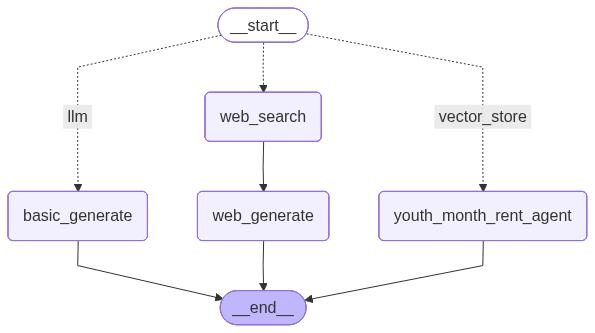

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
initial_state = {"query": "대한민국의 수도는 어디인가요?"}
graph.invoke(initial_state)

{'query': '대한민국의 수도는 어디인가요?', 'answer': '대한민국의 수도는 서울입니다.'}

In [12]:
initial_state = {'query': '청년월세지원금 최대 몇 개월 지원해주나요?'}
graph.invoke(initial_state)

{'query': '청년월세지원금 최대 몇 개월 지원해주나요?',
 'context': [Document(id='35e7ceec-8756-434d-aeed-d9ee66a84592', metadata={'source': './documents/청년월세지원.txt'}, page_content="2025년 서울시 청년월세지원 모집 공고\n서울시에서는 “서울특별시 청년주거 기본 조례 제7조”에 의거 청년의 주거비 부담 완화를 위해 다음과 같이 2025년 '서울시 청년월세지원 사업' 참여자를 모집하오니 많은 참여 바랍니다.\n2025년 6월 4일\n서울특별시장\n1. 사업 개요\n\n사업명: 2025년 서울시 청년월세지원 사업\n지원대상: 신청일 기준 서울시 월세 거주, 19세~39세 이하 청년 1인 가구\n  ※ 서울시 청년월세지원 기수혜자 및 국토교통부 청년희망시스템 특례지원 수혜 중인 자, '25년 자치구 자체 청년월세지원 사업(운평, 광진 등) 지원자로 선정된 사람은 지원 불가\n\n지원내용\n\n지원금액: 월 최대 20만원(최대 12개월/240만원) ※ 생애 1회  \n20만원 미만 월세 계약은 임대차계약서에 표기된 월세 금액만 지원(천원 단위 절삭 예시 차임) 108,000원 이상은 10만원 지원/ 관리비가 포함된 경우 관리비를 제외하고 월세만 지원\n서울형 주택바우처 수급자인 경우, 바우처 수급액을 제외한 차액 지급\n서울시 청년월세 지원 대상자 최종 선정 후 12개월간 지급\n\n신청접수\n\n신청기간: 2025. 6. 11.(수) 10:00 ~ 6. 24.(화) 18:00 (마감)\n신청인원: 15,000명\n신청방법: 서울주거포털 온라인 신청\n\n선정 및 지급\n\n선정방법: 임차보증금-월세 및 소득기준 4개 구간으로 나누어 선정하고 인원 초과시 구간별 전산 추첨\n지급방법: 각월 25일 전후로 계좌 입금\n지급일정: 10월(7월, 8월, 9월), 12월(10월, 11월분) 지급 이후, 잔여 7개월분은 '26년에 지급 예정 (※ 지급일정 변경 가능)

In [13]:
initial_state = {"query": "역삼 맛집을 추천해주세요"}
graph.invoke(initial_state)

{'query': '역삼 맛집을 추천해주세요',
 'context': [{'title': '역삼 맛집 베스트 추천 top 10',
   'url': 'https://hotel-iu.tistory.com/2916',
   'content': "|  |\n\n| 10: 옥된장 역삼점 |\n|  |\n| 상호명: 옥된장 역삼점  주소: 서울특별시 강남구 역삼동 738-6 지상1층  전화번호: 02-555-8466  관련 키워드: 키워드 미입력  관련 태그: ['데이트하기 좋은', '모임하기 좋은', '젊고 캐쥬얼한']  영업시간: 미입력 |\n| 소개글: 옥된장의 옥은 屋(집 옥) 입니다. 저희 어머니가 집에서 만든 된장찌개의 맛을 손님에게 대접하고 싶어 만든 매장입니다.  어머니의 마음처럼 음식을 가장 따뜻하게 드실 수 있도록 전골로 준비했습니다.  그리고 저희 어머니께서는 아직도 김을 직접 구워주시는데 그게 너무 맛있어 엄마가 집에서 직접 구워주듯 바삭하게 구워낸 김을 내어드리기로 했습니다.  마지막으로 김치찜은 제가 가장 좋아하는 반찬이라 준비했습니다.  옥된장에서 점심에는 된장전골에 맛있는 밥 한 끼 드시고 저녁에는 소고기 수육에 술 한잔할 수 있는 공간이 되는 역삼 맛집이 되겠습니다.  오늘도 된장전골은 따뜻합니다. |\n|  옥된장 역삼점 바로가기▲ |\n\n반응형\n\n저작자표시 비영리 변경금지  (새창열림)\n\n#### '추천 TOP 10' 카테고리의 다른 글 [...] | 9: 쇠뚜레 선릉점 |\n|  |\n| 상호명: 쇠뚜레 선릉점  주소: 서울특별시 강남구 역삼동 700-21 1층  전화번호: 미입력  관련 키워드: 키워드 미입력  관련 태그: ['모임하기 좋은', '단체회식']  영업시간: 평일 10:00~23:00 | 주말 17:00~22:00 연중무휴 |\n| 소개글: [당일 발골 당일 판매 한정 판매]  39년 소고기만 다뤄왔습니다 사료가 아닌, 보리곡물을 먹인 특허받은 국내산만 취급합니다  고기의 맛과 질이 어느 한우집과 견주어도 뒤쳐